### WebNLG Challenge 2023¶

The WebNLG challenge consists in mapping data to text. For instance, given the 3 DBpedia triples shown in (a), the aim is to generate a text such as (b).

a. (John_E_Blaha birthDate 1942_08_26) (John_E_Blaha birthPlace San_Antonio) (John_E_Blaha occupation Fighter_pilot)
b. John E Blaha, born in San Antonio on 1942-08-26, worked as a fighter pilot.

More info: https://synalp.gitlabpages.inria.fr/webnlg-challenge/

Link to this colab file: https://drive.google.com/file/d/1evGzcuSOTtxoFguQiJHFLFfyQDze5mK3/view?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install timm

In [4]:
import gc
import pandas as pd
import numpy as np
import os
import torch
import glob
import pathlib
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
import math
warnings.filterwarnings('ignore')
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')

root_data = '/content/drive/MyDrive/webNLG/PROJECT/Data/'
root = '/content/drive/MyDrive/webNLG/PROJECT/modified/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


# **Setting up the dataset**

First convert the .xml file to csv

In [ ]:
#pathlib.Path(output_folder).mkdir(exist_ok=True)

#dataset_names = [
    #'University', 'Airport', 'Astronaut', 'Building', 'City', 'ComicsCharacter', 
    #'Food', 'Monument', 'SportsTeam', 'WrittenWork']

#for name in dataset_names:
  #train_path = os.path.join(root_data, f'{name}.xml')
  #train_path_csv = os.path.join(root, f'{name}.csv')

  #dev_path = os.path.join(root_data, f'dev/{name}_dev.xml')
  #dev_path_csv = os.path.join(root, f'{name}_dev.csv')

  #test_path = os.path.join(root_data, f'test/{name}_test.xml')
  #test_path_csv = os.path.join(root, f'{name}_test.csv')

  #!python root_data + xml-csv_script.py {train_path} {train_path_csv}
  #!python root_data + xml-csv_script.py {dev_path} {dev_path_csv}
  #!python root_data + xml-csv_script.py {test_path} {test_path_csv}

In [ ]:
#pathlib.Path(output_folder).mkdir(exist_ok=True)

#dataset_names = [
    #'University', 'Airport', 'Astronaut', 'Building', 'City', 'ComicsCharacter', 
    #'Food', 'Monument', 'SportsTeam', 'WrittenWork']

#for name in dataset_names:
  #train_path = os.path.join(root_data, f'{name}.xml')
  #train_path_csv = os.path.join(root, f'{name}.csv')

  #dev_path = os.path.join(root_data, f'dev/{name}_dev.xml')
  #dev_path_csv = os.path.join(root, f'dev/{name}_dev.csv')

  #test_path = os.path.join(root_data, f'test/{name}_test.xml')
  #test_path_csv = os.path.join(root, f'test/{name}_test.csv')

  #!python root_data + xml-csv_script.py {train_path} {train_path_csv}
  #!python root_data + xml-csv_script.py {dev_path} {dev_path_csv}
  #!python root_data + xml-csv_script.py {test_path} {test_path_csv}

Combine the different dataset for both the train and dev set into one df

In [ ]:
root = root

def combine_train_dev(root, files_path, new_file):
  path_to_csv_files = glob.glob(root + files_path);

  # Read each CSV file into a DataFrame and this creates a list of dataframes
  data_list = (pd.read_csv(file) for file in path_to_csv_files);

  # Concatenate all DataFrames
  all_data  = pd.concat(data_list, ignore_index=True);
  all_data.drop('prefix', inplace=True, axis=1)
  all_data.to_csv(root + f"{new_file}.csv", index=False) #save to new csv file

In [ ]:
combine_train_dev(root, '*.csv', 'train') #for train.csv files

In [ ]:
combine_train_dev(root, 'dev/*.csv', 'dev/dev') #for dev.csv files

In [ ]:
train_data = pd.read_csv(root +'train.csv');
dev_data = pd.read_csv(root +'dev/dev.csv');
train_data.head(10)

,input_text,target_text
0,['1_Decembrie_1918_University | city | Alba_Iu...,"['The ""1 Decembrie 1918 University"" is in the ..."
1,['1_Decembrie_1918_University | country | Roma...,['The 1 Decembrie 1918 University is located i...
2,"['1_Decembrie_1918_University | latinName | ""U...",['The Latin name of the 1 Decembrie 1918 Unive...
3,['1_Decembrie_1918_University | nickname | Uab'],['The 1 Decembrie 1918 University has the nick...
4,"['1_Decembrie_1918_University | rector | ""Brea...",['Breaz Valer Daniel is rector of the 1 Decemb...
5,['AWH_Engineering_College | academicStaffSize ...,['The academic staff at the AWH Engineering Co...
6,"['AWH_Engineering_College | city | ""Kuttikkatt...",['The AWH Engineering College is located in Ku...
7,['AWH_Engineering_College | country | India'],['AWH Engineering College is located in India.']
8,['AWH_Engineering_College | established | 2001'],['The AWH Engineering College was established ...
9,['AWH_Engineering_College | state | Kerala'],['AWH Engineering College is located in Kerala...


## **Text Preprocessing**

1. Include a space in all joined letters like latinName = latin Name

In [ ]:
def process_csv_file(input_file_path, output_file_path):
    data = pd.read_csv(input_file_path)
    data['input_text'] = data['input_text'].astype(str)
    for index, row in data.iterrows():
        input_text = row['input_text']
        input_text_new = ""
        i = 0
        while i < len(input_text):
            if input_text[i] == "|":
                input_text_new += input_text[i]
                i += 1
                while i < len(input_text) and input_text[i] != "|":
                    if input_text[i].isupper():
                        input_text_new += " "
                    input_text_new += input_text[i]
                    i += 1
                input_text_new += "|"
            else:
                input_text_new += input_text[i]
                i += 1
        input_text_new = input_text_new.replace("||", "|")
        data.at[index, 'input_text'] = input_text_new
    data.to_csv(output_file_path, index=False)


In [ ]:
process_csv_file(root +'train.csv', root +'new_train.csv')
train_data = pd.read_csv(root +'new_train.csv')
train_data.head(10)

,input_text,target_text
0,['1_Decembrie_1918_University | city | Alba_ ...,"['The ""1 Decembrie 1918 University"" is in the ..."
1,['1_Decembrie_1918_University | country | Rom...,['The 1 Decembrie 1918 University is located i...
2,"['1_Decembrie_1918_University | latin Name | ""...",['The Latin name of the 1 Decembrie 1918 Unive...
3,['1_Decembrie_1918_University | nickname | Ua...,['The 1 Decembrie 1918 University has the nick...
4,"['1_Decembrie_1918_University | rector | "" Bre...",['Breaz Valer Daniel is rector of the 1 Decemb...
5,['AWH_Engineering_College | academic Staff Siz...,['The academic staff at the AWH Engineering Co...
6,"['AWH_Engineering_College | city | "" Kuttikkat...",['The AWH Engineering College is located in Ku...
7,['AWH_Engineering_College | country | India']|,['AWH Engineering College is located in India.']
8,['AWH_Engineering_College | established | 2001']|,['The AWH Engineering College was established ...
9,['AWH_Engineering_College | state | Kerala']|,['AWH Engineering College is located in Kerala...


In [ ]:
process_csv_file(root +'dev/dev.csv', root +'dev/new_dev.csv');

2. The above function included " " before all uppercase letters, which included the acronym i.e (ISBN_number = I S B N_number). <br> <br>So, the below function is to convert all uppercase letters to lowercase excluding acronyms while removing the space between the acronyms **e.g** (latin Name = latin name) and (I S B N = ISBN)

In [ ]:
def process_acronyms(input_string):
    # Split the string by space to get all words
    words = input_string.split(' ')

    # Process each word
    new_words = []
    temp_word = ''
    for word in words:
        # If it is an acronym (uppercase) or tag, join it to temp_word
        if word.isupper() or '_' in word:
            temp_word += word
        else:
            # If it is not an acronym or tag, make it lowercase and add it to new_words
            if temp_word:
                new_words.append(temp_word)
                temp_word = ''
            new_words.append(word.lower())

    # Add the last temp_word if it is not empty
    if temp_word:
        new_words.append(temp_word)

    # Join all new words by space
    return ' '.join(new_words)

In [ ]:
train_data['input_text'] = train_data['input_text'].astype(str)
train_data['input_text'] = train_data['input_text'].apply(process_acronyms)

train_data.to_csv(root + 'new_train.csv', index=False)
train_data = pd.read_csv(root + 'new_train.csv')
train_data.head()

,input_text,target_text
0,['1_Decembrie_1918_University | city | Alba_ ...,"['The ""1 Decembrie 1918 University"" is in the ..."
1,['1_Decembrie_1918_University | country | rom...,['The 1 Decembrie 1918 University is located i...
2,"['1_Decembrie_1918_University | latin name | ""...",['The Latin name of the 1 Decembrie 1918 Unive...
3,['1_Decembrie_1918_University | nickname | ua...,['The 1 Decembrie 1918 University has the nick...
4,"['1_Decembrie_1918_University | rector | "" bre...",['Breaz Valer Daniel is rector of the 1 Decemb...


In [ ]:
#For DEV
dev_data['input_text'] = dev_data['input_text'].astype(str)
dev_data['input_text'] = dev_data['input_text'].apply(process_acronyms)

dev_data.to_csv(root + 'dev/new_dev.csv', index=False)

3. Remove all unwanted characters from both columns

In [ ]:
def replace_chars(df):
    # Ensure the input is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError('Input should be a pandas DataFrame.')
       
    # Check if the required columns exist
    if 'input_text' not in df.columns or 'target_text' not in df.columns:
        raise ValueError('DataFrame should contain "input_text" and "target_text" columns.')
   
    # List of characters to replace
    chars_to_replace = ['[', ']', '_', "'", '"']

    # Replace specified characters with space in 'input_text' column
    for char in chars_to_replace:
        df['input_text'] = df['input_text'].str.replace(char, ' ')
       
    # Replace specified characters with space in 'target_text' column
    for char in chars_to_replace:
        df['target_text'] = df['target_text'].str.replace(char, ' ')
   
    return df

In [ ]:
cleaned_train_data = replace_chars(train_data)
cleaned_train_data.to_csv(root + 'clean_train.csv', index=False)
cleaned_train_data.head(10)

,input_text,target_text
0,1 Decembrie 1918 University | city | Alba ...,The 1 Decembrie 1918 University is in the ...
1,1 Decembrie 1918 University | country | rom...,The 1 Decembrie 1918 University is located i...
2,1 Decembrie 1918 University | latin name | ...,The Latin name of the 1 Decembrie 1918 Unive...
3,1 Decembrie 1918 University | nickname | ua...,The 1 Decembrie 1918 University has the nick...
4,1 Decembrie 1918 University | rector | bre...,Breaz Valer Daniel is rector of the 1 Decemb...
5,AWH Engineering College | academic staff siz...,The academic staff at the AWH Engineering Co...
6,AWH Engineering College | city | kuttikkat...,The AWH Engineering College is located in Ku...
7,AWH Engineering College | country | india |,AWH Engineering College is located in India.
8,AWH Engineering College | established | 2001 |,The AWH Engineering College was established ...
9,AWH Engineering College | state | kerala |,AWH Engineering College is located in Kerala...


In [ ]:
#For DEV
cleaned_dev_data = replace_chars(dev_data)
cleaned_dev_data.to_csv(root + 'dev/clean_dev.csv', index=False)
cleaned_dev_data.head(10)

,input_text,target_text
0,Accademia di Architettura di Mendrisio | aca...,The academic staff size of Accademia di Arch...
1,Acharya Institute of Technology | campus | ...,The campus address for the Acharya Institue ...
2,Alba Iulia | country | romania,"Alba Iulia is located in Romania. , Alba Iu..."
3,Alba Iulia | ispartof | Alba County,"Alba Iulia os part of the county of Alba. , ..."
4,romania | patronsaint | Andrew the Apostle,The patron Saint of Romania is Andrew the Ap...
5,school of business and social sciences at th...,The academic staff of the School of Business...
6,school of business and social sciences at th...,The Aarhus University School of Business and...
7,aarhus | leadername | Jacob Bundsgaard,The leader of Aarhus is Jacob Bundsgaard.
8,Aarhus Airport | runwaylength | 2702.0,"Aarhus Airport s runway length is 2702.0. , ..."
9,Adirondack Regional Airport | elevationAbove...,Adirondack Regional Airport is 507 metres ab...


### **List of all train dataset**

In [6]:
#TRAIN
raw_train_data = pd.read_csv(root + 'train.csv') 
lowercase_train_data = pd.read_csv(root +'new_train.csv') #dataset with space included and also converted to lowercase
processed_train_data = pd.read_csv(root + 'clean_train.csv') #final processed dataset with all unwanted characters removed.

#DEV
raw_dev_data = pd.read_csv(root + 'dev/dev.csv')
lowercase_dev_data = pd.read_csv(root + 'dev/new_dev.csv')
processed_dev_data = pd.read_csv(root + 'dev/new_dev.csv')

In [7]:
raw_train_data = raw_train_data.iloc[:4500,:]
raw_train_data = raw_train_data.sample(frac=1)
batch_size = 8
num_of_batches = math.floor(len(raw_train_data)/batch_size)

In [8]:
raw_train_data.head()

,input_text,target_text
1253,['Spain | demonym | Spaniards'],"['Spaniards are from Spain.', 'Spaniards is th..."
1434,['Agremiação_Sportiva_Arapiraquense | chairman...,['The title of the chairman of Agremiacao Spor...
1030,['Antioquia_Department | country | Colombia'],['The Antioquia Department is found in Colombi...
1085,['Baked_Alaska | country | China'],"['Baked Alaska is a dish in China.', 'Baked Al..."
1029,['Andalusia | leaderName | Susana_Díaz'],"['Susana Diaz is a leader of Andalusia.', 'Sus..."


In [9]:
#moving the model to device(GPU/CPU)
%%capture
from transformers import T5Tokenizer, T5ForConditionalGeneration,Adafactor
#from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
model.to(dev)

###Loading the Optimizer

In [10]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [11]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [12]:
num_of_epochs=10

###Train the model

In [13]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1, num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss = 0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):

    inputbatch = []
    labelbatch = []
    new_data= raw_train_data[i*batch_size:i*batch_size+batch_size]
    for index,row in new_data.iterrows():
      input = row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'    
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch = tokenizer.batch_encode_plus(inputbatch,truncation=True,padding=True,return_tensors ='pt')["input_ids"]
    labelbatch = tokenizer.batch_encode_plus(labelbatch,truncation=True,padding=True,return_tensors ="pt") ["input_ids"]
    inputbatch = inputbatch.to(dev)
    labelbatch = labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num = loss.item()
    logits = outputs.logits
    running_loss += loss_num
    if i%10 == 0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
  
  running_loss = running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.5204515783241511
Running epoch: 2


Epoch: 2 , Running loss: 0.3073662500410871
Running epoch: 3


Epoch: 3 , Running loss: 0.2538706296428437
Running epoch: 4


Epoch: 4 , Running loss: 0.21598317343825182
Running epoch: 5


Epoch: 5 , Running loss: 0.18624892710570262
Running epoch: 6


Epoch: 6 , Running loss: 0.16585319128405354
Running epoch: 7


Epoch: 7 , Running loss: 0.14905148520731606
Running epoch: 8


Epoch: 8 , Running loss: 0.1325362800816784
Running epoch: 9


Epoch: 9 , Running loss: 0.11868536879930795
Running epoch: 10


Epoch: 10 , Running loss: 0.10764744354938177


### Ploting for Loss

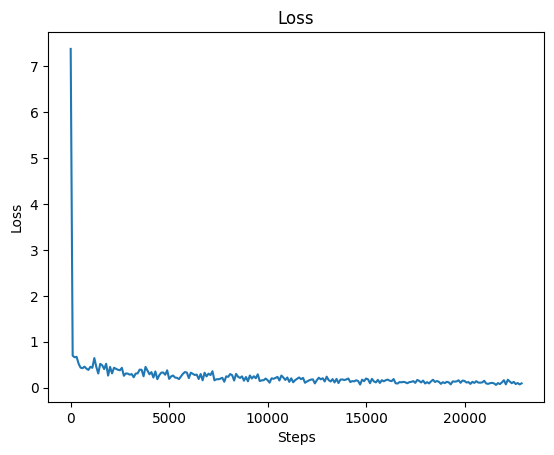

In [14]:
steps = [i*100 for i in range(len(loss_per_10_steps))] 
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

### Testing the Model

In [15]:
model.eval()
input_ids = tokenizer.encode("Russia | leader | Putin", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0], skip_special_tokens=True)     

"['The leader of Russia is Putin.', 'Presidential is the"

In [16]:
model.eval()
input_ids = tokenizer.encode("Russia | leader | Putin", return_tensors="pt")  # Batch size 1
input_ids = input_ids.to(dev)
outputs = model.generate(input_ids)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Split the generated text by newline character
lines = generated_text.split('\n')

# Remove any empty strings from the list of lines
lines = [line.strip() for line in lines if line.strip()]

# Print the lines with corresponding indices
for i, line in enumerate(lines, 1):
    print(f"{i}. {line}")

1. ['The leader of Russia is Putin.', 'Presidential is the


In [17]:
def make_prediction(model, text):

   model.eval()
   input_ids = tokenizer.encode(text, return_tensors="pt").to(dev)  # Batch size 1
   s = time.time()
   outputs = model.generate(input_ids)
   gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
   elapsed = time.time() - s
   print('Generated in {} seconds'.format(str(elapsed)[:4]))
   return gen_text

make_prediction(model, 'Russia | leader | Putin')

Generated in 0.57 seconds


"['The leader of Russia is Putin.', 'Presidential is the"

#**Evaluating the model**


In [18]:
%%capture
#geting the inputs (input_text) from the dataset
raw_dev_data_inputs = [ x.replace('[','').replace(']','') for x in raw_dev_data['input_text'].values.tolist() ]

#feeding the input into the model and getting the predictions
raw_dev_data_pred = [ make_prediction(model, x) for x in raw_dev_data_inputs ]

#loading the reference values from the target_text column
raw_dev_data_ref = [ x.replace('[','').replace(']','') for x in raw_dev_data['target_text'].values.tolist() ]

In [19]:
## Creating both files for the ref and hypothesis as requested by the eval
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"

file_path_ref = 'raw_dev_reference.txt'
file_path_hypo = 'raw_dev_hypothesis.txt'

# Create or overwrite the files
with open(file_path_ref, 'w', encoding='utf-8') as f:
    for row in raw_dev_data_ref:
        f.write(row + '\n')

with open(file_path_hypo, 'w', encoding='utf-8') as f:
    for row in raw_dev_data_pred:
        f.write(row + '\n')

#### Installing dependencies for eval

In [20]:
%%capture
### No requirement.txt file was found in the repository
!git clone https://github.com/WebNLG/2023-Challenge.git
%pushd 2023-Challenge/evaluation/automatic/scripts
!./install_dependencies.sh
%popd

In [21]:
!pip install meteor pyter3 bert_score razdel tabulate sacrebleu -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 5.0 MB/s eta 0:00:00


In [22]:
#removed meteor because of this 'Error: Unable to access jarfile metrics/meteor-1.5/meteor-1.5.jar'
#removed bleurt because its not implemented in the eval.py (also commented the import code line out)
raw_data_eval = !python {root_data}eval.py -hyp raw_dev_hypothesis.txt -ref raw_dev_reference.txt -nr 1 -m bleu,meteor,bert,chrf++,ter -lng en

In [23]:
raw_data_eval_df = raw_data_eval[-3:]
raw_data_eval_df

#result = pd.DataFrame(raw_data_eval_df)
#result.to_csv(root + 'result.csv', index=False)

['   BLEU    METEOR    chrF++    TER    BERT-SCORE P    BERT-SCORE R    BERT-SCORE F1',
 '-------  --------  --------  -----  --------------  --------------  ---------------',
 '15.6961        -1      0.35   0.69            0.92             0.9             0.91']